# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

**Estimated Run Time:** 5 minutes

This notebooks outlines the process of generating unbiased candidate mechanisms and comparing them to the dogmatic mechanisms from the [NeuroMMSig Database](http://neurommsig.scai.fraunhofer.de/).

### Notebook Imports

In [1]:
import logging
import itertools as itt
import os
import time
from collections import defaultdict
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2

import pybel
import pybel_tools as pbt
import pybel_tools.analysis.npa as npa
from pybel.canonicalize import calculate_canonical_name
from pybel.constants import *
from pybel_tools.visualization import to_jupyter

In [2]:
#%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Notebook Provenance

The time of execution, random number generator seed, and the versions of the software packegs used are displayed explicitly.

In [3]:
time.asctime()

'Thu Mar 23 14:49:00 2017'

In [4]:
# seed the random number generator
import random
random.seed(127)

In [5]:
pybel.__version__

'0.4.4-dev'

In [6]:
pbt.__version__

'0.1.4-dev'

### Local Path Definitions

To make this notebook interoperable across many machines, locations to the repositories that contain the data used in this notebook are referenced from the environment, set in `~/.bashrc` to point to the place where the repositories have been cloned. Assuming the repositories have been `git clone`'d into the `~/dev` folder, the entries in `~/.bashrc` should look like:

```bash
...
export BMS_BASE=~/dev/bms
...
```

#### BMS 

The biological model store (BMS) is the internal Fraunhofer SCAI repository for keeping BEL models under version control. It can be downloaded from https://tor-2.scai.fraunhofer.de/gf/project/bms/

In [7]:
bms_base = os.environ['BMS_BASE']

## Alzheimer's Disease Knowledge Assembly

The Alzheimer's Disease knowledge assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [8]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')

In [9]:
graph = pybel.from_pickle(pickle_path)

## Summary of Subgraphs and Biological Processes

The names of the dogmatic mechanisms are extracted and listed below.

In [10]:
dogmatic_mechanism_names = sorted(pbt.summary.get_annotation_values(graph, 'Subgraph'))

In [11]:
len(dogmatic_mechanism_names)

126

The BEL graph object is split to multiple BEL graph objects representing each of the subgraphs with [pbt.selection.get_subgraph_by_annotation](http://pybel-tools.readthedocs.io/en/latest/selection.html#pybel_tools.selection.get_subgraph_by_annotation).

In [12]:
%%time

dogmatic_mechanisms = {}

for dogmatic_mechanism_name in dogmatic_mechanism_names:
    dogmatic_mechanism = pbt.selection.get_subgraph_by_annotation(graph, dogmatic_mechanism_name)
    # TODO filters?
    dogmatic_mechanisms[dogmatic_mechanism_name] = dogmatic_mechanism

CPU times: user 14 s, sys: 65.2 ms, total: 14.1 s
Wall time: 14.1 s


### Biological Processes to Dogmatic Subgraphs

All biological process nodes are retrieved with [pbt.selection.get_nodes_by_function](http://pybel-tools.readthedocs.io/en/latest/selection.html#pybel_tools.selection.get_nodes_by_function).

In [13]:
bioprocess_nodes = sorted(pbt.selection.get_nodes_by_function(graph, BIOPROCESS))

In [14]:
len(bioprocess_nodes)

440

Which bioprocesses appear in multiple dogmatic mechanisms? The upstream controllers of these nodes in the knowledge assembly will be direct evidence for cross talk.

In [15]:
bp2dm = defaultdict(set)

for dogmatic_mechanism_name, dogmatic_mechanism in dogmatic_mechanisms.items():
    for bp in pbt.selection.get_nodes_by_function(dogmatic_mechanism, BIOPROCESS):
        bp2dm[bp].add(dogmatic_mechanism_name)
        
bp2dm = dict(bp2dm)

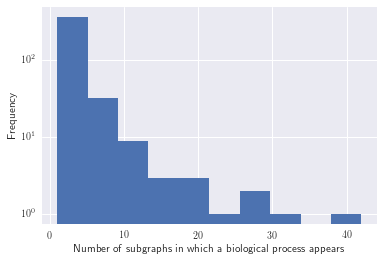

In [16]:
bp2dm_counts = pbt.utils.count_dict_values(bp2dm)

plt.ylabel('Frequency')
plt.xlabel('Number of subgraphs in which a biological process appears')
plt.hist(list(bp2dm_counts.values()), log=True)
plt.show()

The top 25 most frequent biological processes are shown below.

In [17]:
for bp, count in bp2dm_counts.most_common(25):
    print('{:2} {:6} {}'.format(count, graph.node[bp][NAMESPACE], graph.node[bp][NAME]))

42 GOBP   apoptotic process
30 GOBP   neuron apoptotic process
28 GOBP   neuron death
26 GOBP   cognition
24 GOBP   cell death
20 MESHPP Oxidative Stress
20 GOBP   memory
20 GOBP   inflammatory response
15 GOBP   calcium ion import
14 GOBP   response to oxidative stress
14 GOBP   microglial cell activation
12 GOBP   learning
12 MESHPP Apoptosis
11 MESHPP Insulin Resistance
11 GOBP   regulation of synaptic plasticity
10 GOBP   negative regulation of neuron apoptotic process
10 GOBP   calcium-mediated signaling
10 GOBP   insulin receptor signaling pathway
10 GOBP   endocytosis
10 GOBP   microglial cell activation involved in immune response
 9 GOBP   beta-amyloid formation
 9 GOBP   synaptic transmission
 9 GOBP   neuron projection development
 9 MESHPP Neurogenesis
 9 GOBP   cytoskeleton organization


### Dogmatic Subgraphs to Biological Processes

Conversely, how many biological processes appear in each mechanism?

In [18]:
dm2bp = {}

for dogmatic_mechanism_name, dogmatic_mechanism in dogmatic_mechanisms.items():
    dm2bp[dogmatic_mechanism_name] = set(pbt.selection.get_nodes_by_function(dogmatic_mechanism, BIOPROCESS))

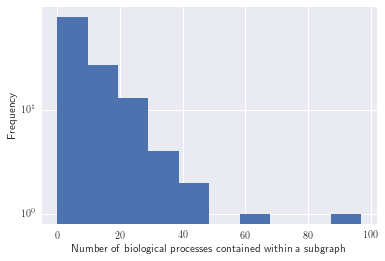

In [19]:
dm2bp_counts = pbt.utils.count_dict_values(dm2bp)

plt.ylabel('Frequency')
plt.xlabel('Number of biological processes contained within a subgraph')
plt.hist(list(dm2bp_counts.values()), log=True)
plt.show()

The top 25 highest biological-process dense subgraphs are shown below.

In [20]:
for dogmatic_mechanism_name, count in dm2bp_counts.most_common(25):
    print('{:2} {}'.format(count, dogmatic_mechanism_name))

97 Amyloidogenic subgraph
64 Insulin signal transduction
43 Inflammatory response subgraph
42 Tau protein subgraph
36 Low density lipoprotein subgraph
34 Gamma secretase subgraph
33 Acetylcholine signaling subgraph
30 MAPK-ERK subgraph
29 Cyclin-CDK subgraph
29 Non-amyloidogenic subgraph
28 Glutamatergic subgraph
26 Reactive oxygen species subgraph
25 Calcium-dependent signal transduction
23 Tumor necrosis factor subgraph
22 Phosphatidylinositol 3 subgraph
22 Regulation of cytoskeleton subgraph
21 Chemokine signaling subgraph
21 GSK3 subgraph
21 Interleukin signaling subgraph
21 Nitric oxide subgraph
20 Caspase subgraph
19 ApoE subgraph
19 CREB subgraph
19 Response to oxidative stress
17 Endosomal lysosomal subgraph


### Annotation Landscape

The biological process to dogmatic subgraph membership matrix is calculated, clustered, and plotted below.

In [21]:
dm_bp_membership = defaultdict(dict)
dm_bp_membership_bool = defaultdict(dict)

for dogmatic_mechanism_name, bp in itt.product(dogmatic_mechanism_names, bioprocess_nodes):
    dm_bp_membership_bool[dogmatic_mechanism_name][bp] = bp in dm2bp[dogmatic_mechanism_name]
    dm_bp_membership[dogmatic_mechanism_name][bp] = 1 if bp in dm2bp[dogmatic_mechanism_name] else 0
    
dm_bp_membership = dict(dm_bp_membership)
dm_bp_membership_bool = dict(dm_bp_membership_bool)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


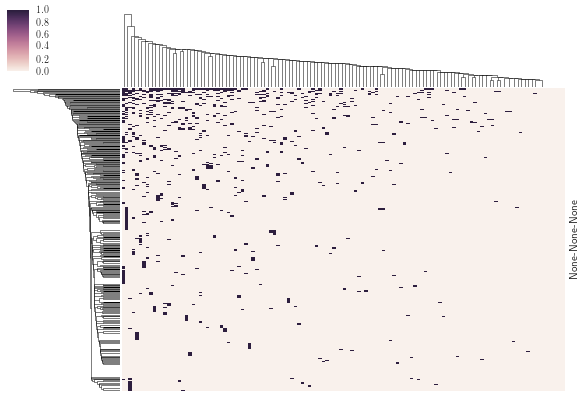

In [22]:
membership_df = pd.DataFrame(dm_bp_membership)

#plt.title('Landscape of membership of biological processes to dogmatic subgraphs')
#plt.ylabel('Biological process')
#plt.xlabel('Dogmatic subgraph')

sg = sns.clustermap(membership_df, xticklabels=False, yticklabels=False, figsize=(10, 7))

plt.show()

## Generated Unbiased Mechanisms

Each subgraph annotation in the NeuroMMSig Database comes from a specific domain of study. While these dogmatic mechanisms are helpful for communicating ideas, they are a discretization of the continuous and inseperable biological system. In this section, we will generate more, smaller candidate subgraphs with an unbiased approach in hopes of providing a more thorough overview of the individual mechanisms in the hollistic system and their interplay or "cross-talk". Later, we'll use that information to assess the overlap between dogmatic mechanisms and bridge the gaps between them.

The mechanisms themselves are generated with [pbt.generation.generate_bioprocess_mechanisms](http://pybel-tools.readthedocs.io/en/latest/generation.html#pybel_tools.generation.generate_bioprocess_mechanisms) by expanding to the upstream controllers around each biological process.

In [23]:
%%time
candidate_mechanisms = pbt.generation.generate_bioprocess_mechanisms(graph)

CPU times: user 3.47 s, sys: 49.9 ms, total: 3.52 s
Wall time: 3.52 s


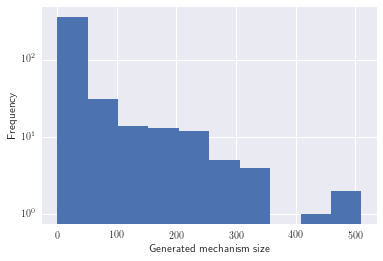

In [24]:
plt.xlabel('Generated mechanism size')
plt.ylabel('Frequency')
plt.hist([len(cm) for cm in candidate_mechanisms.values()], log=True)
plt.show()

## Overlap Summary

The Tversky similarity is calculated between the nodes contained in each candidate mechanism versus each dogmatic subgraph. It is weighted to calculate what percentage of the nodes in a candidate mechanism with $\alpha=1$ and $\beta=0$.

In [25]:
%%time

dm_bp_overlap = defaultdict(dict)

for dogmatic_mechanism_name, bp in itt.product(dogmatic_mechanism_names, bioprocess_nodes):
    x = set(pbt.selection.get_nodes_by_function(candidate_mechanisms[bp], {PROTEIN, BIOPROCESS}))
    y = set(dogmatic_mechanisms[dogmatic_mechanism_name].nodes_iter())
    
    dm_bp_overlap[dogmatic_mechanism_name][bp] = pbt.utils.set_percentage(x, y)
    
dm_bp_overlap = dict(dm_bp_overlap)

CPU times: user 5.89 s, sys: 26.9 ms, total: 5.92 s
Wall time: 5.93 s


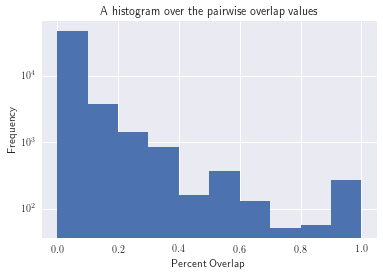

In [26]:
overlap_df = pd.DataFrame(dm_bp_overlap)
overlap_df.to_csv(os.path.expanduser('~/Desktop/subgraph_comparison.csv'))

plt.title('A histogram over the pairwise overlap values')
plt.xlabel('Percent Overlap')
plt.ylabel('Frequency')
plt.hist(overlap_df.as_matrix().ravel(), log=True)
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


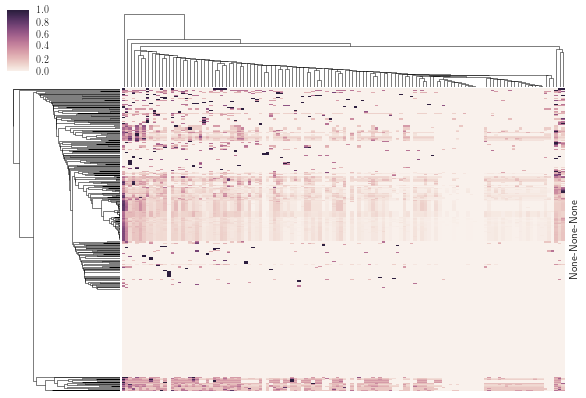

In [27]:
#ax = plt.axes()
#ax.set_title('Landscape of overlap of generated candidate mechanisms to dogmatic subgraphs')
#ax.set_ylabel('Candidate mechanism generated from biological process')
#ax.set_xlabel('Dogmatic subgraph')

cg = sns.clustermap(overlap_df, xticklabels=False, yticklabels=False, figsize=(10, 7))

plt.show()

The overlap similarity matrix is discretized with a cutoff and displayed below.

In [28]:
overlap_cutoff = 0.2

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


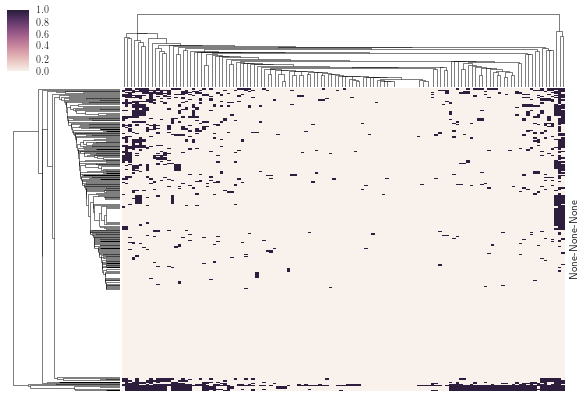

In [29]:
sns.clustermap(overlap_cutoff < overlap_df, xticklabels=False, yticklabels=False, figsize=(10, 7))
plt.show()

## Concordance Calculations

Which dogmatic subgraphs have a significant overlap with candidate mechansims? Of the candidate mechanisms with significant overlap to dogmatic subgraphs, which biological processes were not already part of the dogmatic subgraph?

In [30]:
#: Keeps track of which biological processes have large overlap with a dogmatic mechanism, but wasn't in it
dm_added = {}
dm_bp_cutoff_member = defaultdict(dict)

for dogmatic_mechanism_name in dogmatic_mechanism_names:
    dm_added[dogmatic_mechanism_name] = set()
    for bp in bioprocess_nodes:
        
        concordance = overlap_cutoff < dm_bp_overlap[dogmatic_mechanism_name][bp]
        
        dm_bp_cutoff_member[dogmatic_mechanism_name][bp] = concordance
        
        if bp not in dm2bp[dogmatic_mechanism_name] and concordance:
            dm_added[dogmatic_mechanism_name].add(bp)

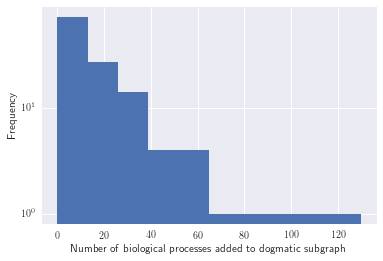

In [31]:
plt.xlabel('Number of biological processes added to dogmatic subgraph')
plt.ylabel('Frequency')
plt.hist([len(v) for v in dm_added.values()], log=True)
plt.show()

Similarity values between the set of added biological processes and the set of contained biological processes for each dogmatic mechanism are calculated. 

Higher similarity means that this approach has lower potential for asserting subgraph expansions, so the values are subtracted from one to preserve monotonicity and improve interpretability.

In [32]:
dm_concordance = {}

for dm in dogmatic_mechanism_names:
    x = dm_added[dm]
    y = {bp for bp in bioprocess_nodes if dm_bp_cutoff_member[dm][bp]}
    
    dm_concordance[dm] = 1 - pbt.utils.tanimoto_set_similarity(x, y)

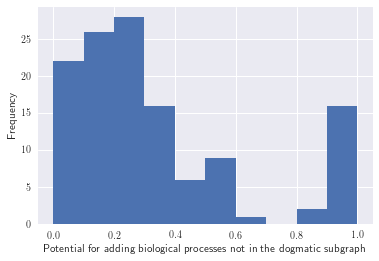

In [33]:
plt.ylabel('Frequency')
plt.xlabel('Potential for adding biological processes not in the dogmatic subgraph')
plt.hist(list(dm_concordance.values()))
plt.show()

The similarity values correspond to which dogmatic subgraphs have the highest potential for expansion, with higher values corresponding to higher potential.

In [34]:
for dm, concordance in sorted(dm_concordance.items(), key=itemgetter(1), reverse=True):
    print('{:.2f} {}'.format(concordance, dm))

1.00 Alcohol dehydrogenase subgraph
1.00 Beta-Oxidation of Fatty Acids
1.00 CRH subgraph
1.00 Cortisol subgraph
1.00 Disaccharide metabolism subgraph
1.00 Dopaminergic subgraph
1.00 Galanin subgraph
1.00 Glycolysis subgraph
1.00 Myeloperoxidase subgraph
1.00 Neurotransmitter release subgraph
1.00 Nucleoside salvage subgraph
1.00 Protein biosynthesis subgraph
1.00 RhoA subgraph
1.00 Smad subgraph
1.00 Syndecan subgraph
1.00 p53 stabilization subgraph
0.86 Serotonergic subgraph
0.83 Blood vessel dilation subgraph
0.67 KANSL1 subgraph
0.60 Retinoblastoma subgraph
0.56 Axonal guidance subgraph
0.50 Cell-cell communication subgraph
0.50 Energy metabolism
0.50 Glutathione reductase subgraph
0.50 Reelin subgraph
0.50 Synapse assembly subgraph
0.50 Vitamin subgraph
0.50 XIAP subgraph
0.44 Tau protein subgraph
0.43 Cell cycle subgraph
0.43 Axonal transport subgraph
0.43 Neuroprotection subgraph
0.42 Amyloidogenic subgraph
0.40 Hydrogen peroxide subgraph
0.40 Insulin signal transduction
0.39 Pho

# Conclusions

Generating unbiased candidate mechanism subgraphs ultimately provides the same insight as painstakingly curated subgraphs. It is also possible to identify high novelty in candidate mechanisms that have little overlap with curated subgraphs and high scores in data driven approaches.